In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
import os, copy, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=0.8)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
print(f'torch.cuda.is_available() = {torch.cuda.is_available()}')
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f'device = {device}, count = {torch.cuda.device_count()}, device_name = {torch.cuda.get_device_name(0)}')
path = "/home/max/Projects/Images_Classification"
models_path = os.path.join(path, 'models')
model_path = os.path.join(models_path, 'Dataset_17072020_ttv_CUT_new.pt')
data_dir = os.path.join(path, "Dataset_17072020_ttv_not_cutted")
test_path = os.path.join(data_dir, "test")

torch.cuda.is_available() = True
1.4.0+cu92
device = cuda:0, count = 1, device_name = GeForce RTX 2070


In [9]:
# Data augmentation and normalization for training Just normalization for validation
data_transforms = {
        'test': transforms.Compose([
            transforms.Resize(size=(224,224), interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=0) for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets['test'].classes
inputs, classes = next(iter(dataloaders['test']))  # Get a batch of training data
out = torchvision.utils.make_grid(inputs)
train_dir = os.path.join(data_dir, "test")
classes_counts = list([(folder, len(os.listdir(os.path.join(train_dir, folder)))) for folder in os.listdir(train_dir)])
print(f'classnames = {class_names}')


classnames = ['Гипертимный', 'Истероидный', 'Паранояльный', 'Тревожный', 'Шизоидный', 'Эмотивный', 'Эпилептоидный']


In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
def visualize_model(model, num_images=7):
        was_training = model.training
        model.eval()
        images_so_far = 0
        fig = plt.figure()
        predictions = []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloaders['test']):
                inputs = inputs#.to(device)
                labels = labels#.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.append(preds)
                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                    imshow(inputs.cpu().data[j])
                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return predictions
            model.train(mode=was_training)

In [13]:
losses_df = pd.read_csv(os.path.join(path, 'losses_df.csv'), index_col=0)
losses_df.head(3)

,epochs,train_losses,val_losses,train_accs,val_accs
0,1,1.742646,1.526736,0.310065,0.410919
1,2,1.430191,1.409789,0.454271,0.463807
2,3,1.309182,1.357701,0.508952,0.483792


In [14]:
epochs = losses_df['epochs'].tolist()
epochs[:4]

[1, 2, 3, 4]

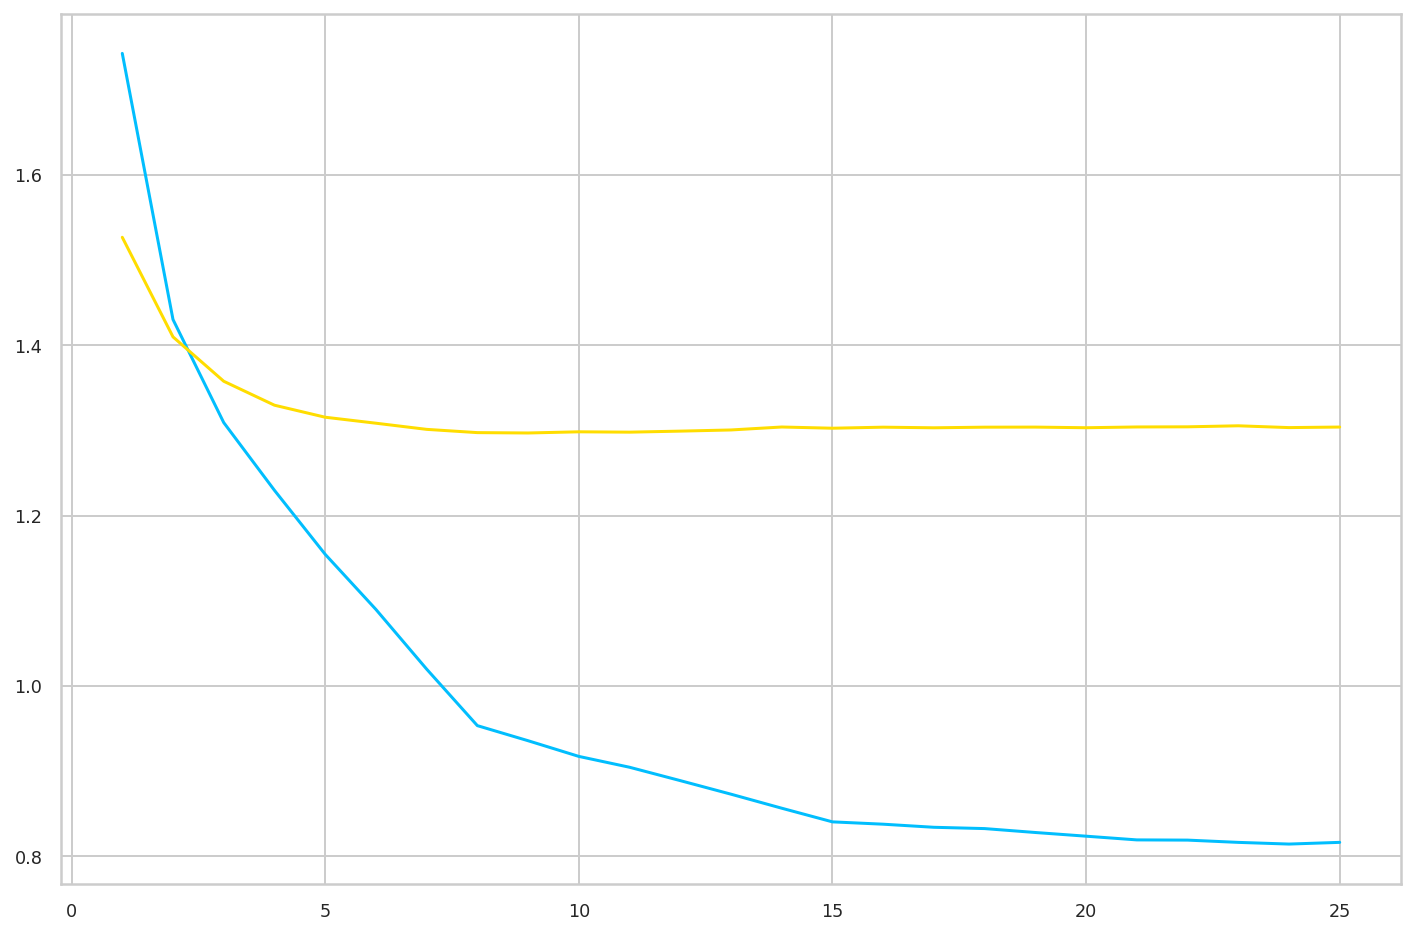

In [15]:
plt.plot(epochs, losses_df['train_losses'].tolist(),
         epochs, losses_df['val_losses'].tolist());

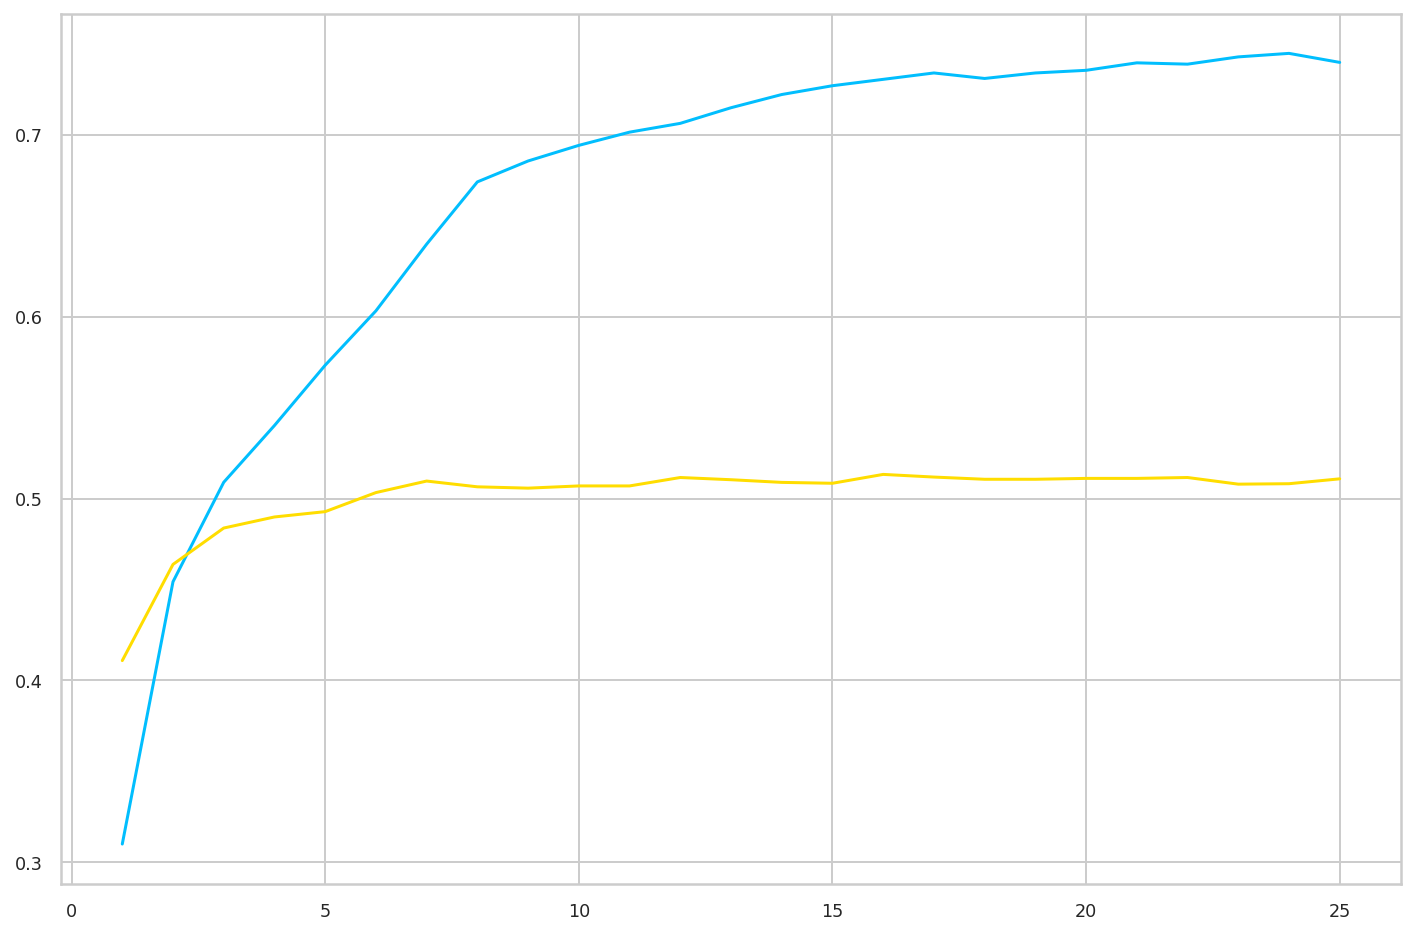

In [16]:
plt.plot(epochs, losses_df['train_accs'].tolist(),
         epochs, losses_df['val_accs'].tolist());

In [17]:
model = torch.load(model_path)

In [18]:
#visualize_model(model, num_images=10)

In [19]:
def get_y_predictions(model, data):
    predicted_y = []
    target_y = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predicted_y.append(preds)
            target_y.append(labels)
            for j in range(inputs.size()[0]):
                target_y.append(int(labels[j]))
                predicted_y.append(int(preds[j]))
    return (predicted_y, target_y)

In [20]:
a = torch.tensor([6], device='cuda:0')
print(int(a[0]))

6


In [21]:
y_preds, y_targets = get_y_predictions(model, dataloaders['test'])
print(y_preds[:3])
print(y_targets[:3])

[tensor([5], device='cuda:0'), 5, tensor([5], device='cuda:0')]
[tensor([0], device='cuda:0'), 0, tensor([0], device='cuda:0')]


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
data_transforms = {
        'test': transforms.Compose([
            transforms.Resize(size=(224, 224), interpolation=2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

from torch.autograd import Variable
test_transforms = data_transforms['test']

def predict_image(model, image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index
from PIL import Image
from tqdm.notebook import tqdm
y_true, y_pred = [], []
for folder in tqdm(os.listdir(test_path)):
    folder_path = os.path.join(test_path, folder)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        img = Image.open(image_path)
        try:
            y_pred.append(predict_image(model, img))
            y_true.append(folder)
        except RuntimeError:
            pass

print(f'y_true[:10] = {y_true[:10]}')
print(f'y_pred[:10] = {y_pred[:10]}')
class_names_to_id = dict(list([(class_names[i], i) for i in range(len(class_names))]))
print(f'class_names_to_id = {class_names_to_id}')
y_true = [class_names_to_id[item] for item in y_true] # y_pred = [id_to_class[i][1] for i in y_pred]
#y_true = torch.as_tensor(np.array(y_true), dtype=int)
#_pred = torch.as_tensor(np.array(y_pred), dtype=int)   #%%
print(y_pred)
print(y_true)
# print(classification_report(y_targets, y_preds))


y_true[:10] = ['Эмотивный', 'Эмотивный', 'Эмотивный', 'Эмотивный', 'Эмотивный', 'Эмотивный', 'Эмотивный', 'Эмотивный', 'Эмотивный', 'Эмотивный']
y_pred[:10] = [4, 4, 1, 0, 0, 4, 3, 5, 3, 6]
class_names_to_id = {'Гипертимный': 0, 'Истероидный': 1, 'Паранояльный': 2, 'Тревожный': 3, 'Шизоидный': 4, 'Эмотивный': 5, 'Эпилептоидный': 6}
[4, 4, 1, 0, 0, 4, 3, 5, 3, 6, 0, 1, 6, 6, 5, 5, 0, 1, 5, 0, 0, 5, 5, 1, 6, 5, 1, 0, 5, 5, 6, 5, 5, 0, 1, 5, 5, 1, 0, 3, 4, 3, 5, 5, 4, 1, 1, 6, 0, 0, 0, 6, 5, 6, 4, 0, 4, 6, 3, 5, 6, 3, 0, 0, 1, 5, 3, 5, 5, 1, 5, 1, 1, 5, 5, 0, 0, 4, 5, 5, 1, 5, 6, 0, 5, 3, 4, 0, 1, 1, 5, 6, 3, 4, 5, 5, 0, 5, 1, 0, 6, 5, 4, 5, 4, 1, 6, 1, 3, 0, 1, 5, 0, 5, 5, 6, 1, 0, 5, 5, 3, 1, 6, 4, 0, 4, 1, 5, 5, 5, 1, 5, 0, 4, 5, 5, 1, 1, 3, 0, 5, 5, 1, 5, 6, 5, 5, 5, 3, 4, 6, 5, 5, 4, 0, 5, 5, 5, 5, 5, 1, 3, 0, 5, 1, 3, 5, 6, 5, 5, 2, 5, 5, 3, 4, 6, 0, 5, 5, 1, 1, 5, 0, 5, 0, 6, 5, 5, 5, 5, 6, 5, 6, 5, 4, 6, 0, 0, 5, 4, 0, 0, 0, 5, 0, 6, 0, 0, 4, 5, 5, 1, 5, 4, 0, 0, 1, 0, 0, 5, 1, 5

In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.38      0.38       196
           1       0.46      0.38      0.41       198
           2       0.74      0.83      0.79       199
           3       0.62      0.70      0.66       191
           4       0.44      0.40      0.42       198
           5       0.32      0.38      0.35       192
           6       0.36      0.30      0.33       192

    accuracy                           0.48      1366
   macro avg       0.47      0.48      0.48      1366
weighted avg       0.47      0.48      0.48      1366



In [42]:
y_targets = y_true
y_preds = y_pred
print(confusion_matrix(y_targets, y_preds))

[[ 74  23   9   9  19  31  31]
 [ 20  75   6   9  18  54  16]
 [  2   6 166   7   7   2   9]
 [  4   4  12 134  22   7   8]
 [ 28  11  10  29  80  21  19]
 [ 32  31   1  16  18  72  22]
 [ 32  14  19  13  19  37  58]]


In [43]:
idx2class = dict([(i, class_names[i]) for i in range(7)])
idx2class

{0: 'Гипертимный',
 1: 'Истероидный',
 2: 'Паранояльный',
 3: 'Тревожный',
 4: 'Шизоидный',
 5: 'Эмотивный',
 6: 'Эпилептоидный'}

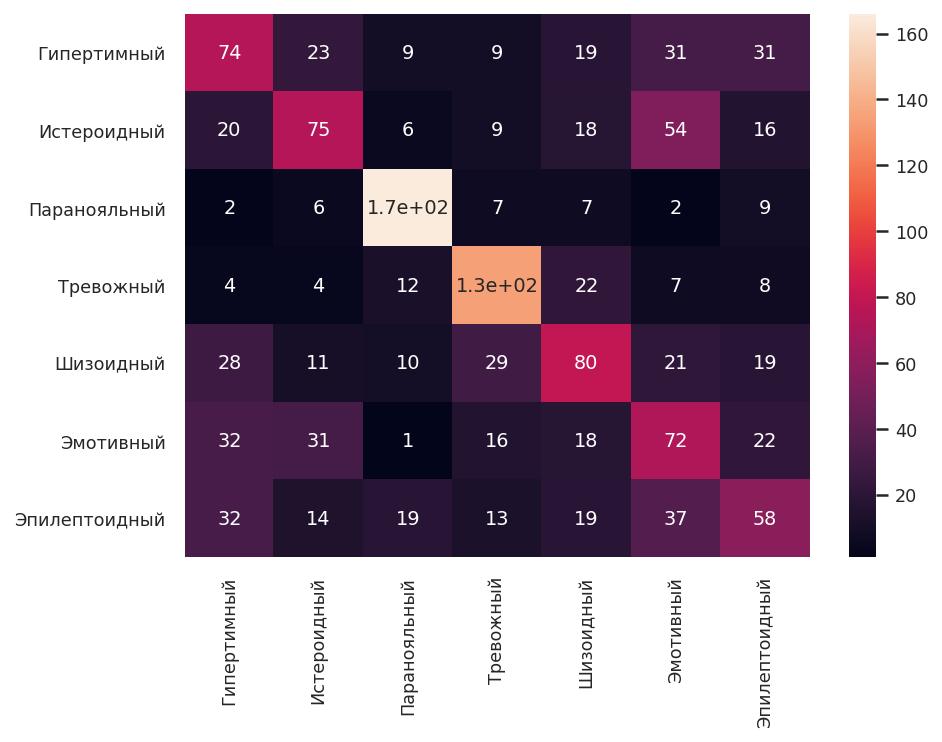

In [44]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_targets, y_preds)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix_df, annot=True, ax=ax);


In [45]:
loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=False, num_workers=4) for x in ['test']}

In [46]:
prediction_loader = torch.utils.data.DataLoader(image_datasets, batch_size=1)

In [47]:
@torch.no_grad()
def get_all_preds(model, loader):
    #all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        images = images
        preds = model(images)
    return preds

In [49]:
#print(get_all_preds(model, loader['test']))